# rPPG Validation Notebook (with or without IR PPG)

This notebook validates **video-based rPPG** extracted from your `*_ppg_data.npz` files.

It supports two modes:

- **With IR CSV** (ground-truth PPG): compare **HR**, **PSD**, **alignment lag**, and optional waveform similarity.
- **Without IR**: check **repeatability / self-consistency** across ROIs (forehead / cheeks) using agreement + quality metrics.

## What “good” looks like (quick intuition)
**Good clip**
- PSD has a **clear peak** in the heart band (usually 0.8–3.0 Hz).
- HR estimates from ROIs are **close** (e.g., within ±5–8 bpm for most windows).
- ROI pixel area (`roi_pixels`) is **stable** (no sudden collapses).
- If IR exists: HR tracks match, and alignment lag is stable (doesn’t jump wildly).

**Bad clip**
- PSD is flat/noisy or peak jumps around.
- ROIs disagree a lot OR one ROI produces random HR.
- `roi_pixels` is unstable (mask “breathing”) or too small.

In [2]:
# --- Install/Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 3)

## 1) Paths (edit this cell)

- `NPZ_PATH`: your video ROI `.npz` file from the extractor.
- `IR_CSV_PATH`: optional IR sensor CSV file. Leave as `None` if you don't have it.

**CSV format assumption:** a single column of samples (or the first column is the samples).  
If you have timestamps or a sampling rate in the file, you can adapt the loader cell below.

In [ ]:
NPZ_PATH = "../data/processed/1_ppg_data.npz"   # <-- edit
IR_CSV_PATH = "../data/IR_PPG_228/1_ir.csv"                           # e.g. "data/ir/1_ir.csv" or None

# If IR_CSV_PATH has no timestamps, we estimate IR sampling rate from duration match.

In [4]:
# --- Load NPZ ---
d = np.load(NPZ_PATH, allow_pickle=True)

fps = float(d["fps"])
t = d["timestamps"].astype(float) if "timestamps" in d else np.arange(int(d["frame_count"])) / fps

rois = {k: d[k].astype(float) for k in ["forehead","left_cheek","right_cheek"] if k in d.files}
roi_pixels = d["roi_pixels"] if "roi_pixels" in d.files else None
face_ok = d["face_ok"] if "face_ok" in d.files else None
meta = d["meta"].item() if "meta" in d.files else {}

print("NPZ:", Path(NPZ_PATH).name)
print("fps:", fps, "frames:", len(t), "duration(s):", t[-1] if len(t) else None)
print("ROIs:", list(rois.keys()))
print("meta:", meta if meta else "(none)")

NPZ: 1_ppg_data.npz
fps: 25.00224517287831 frames: 928 duration(s): 37.0766716003418
ROIs: ['forehead', 'left_cheek', 'right_cheek']
meta: {'skin_mode': 'ycrcb', 'lower_hsv': (0, 20, 70), 'upper_hsv': (20, 255, 255), 'cr': (133, 173), 'cb': (77, 127), 'forehead_height_ratio': 0.22, 'forehead_width_inset': 0.12, 'cheek_shrink': 0.22, 'cheek_bottom_frac': 0.35, 'nose_margin_px': 12, 'mouth_margin_px': 10, 'jaw_margin_px': 18, 'min_pixels': 120}


### 1.1 Quick sanity plots: ROI RGB & ROI pixel area

**What you should see:**
- RGB means are relatively smooth with some variation.
- `roi_pixels` should be reasonably stable. Sudden drops = mask failure or face leaving frame.

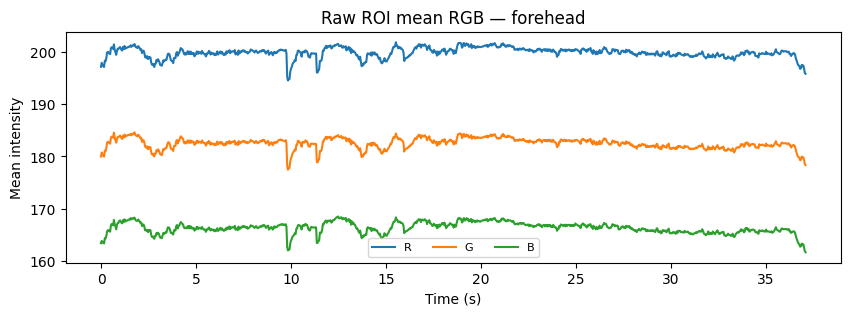

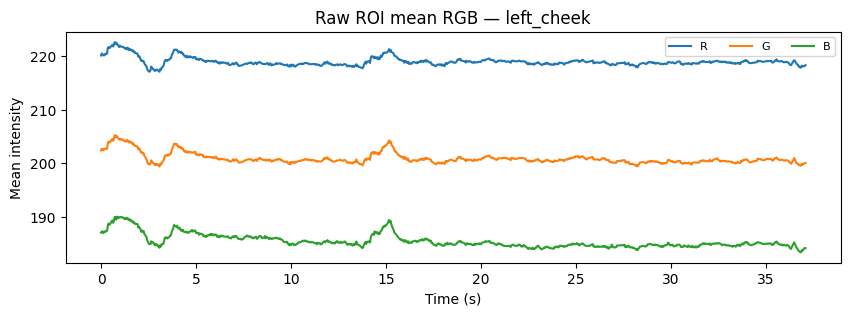

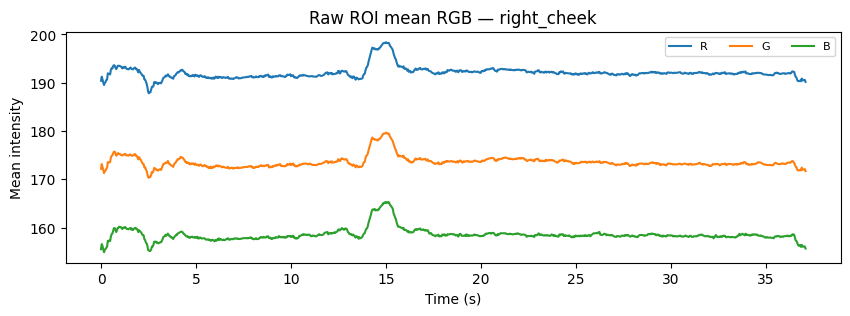

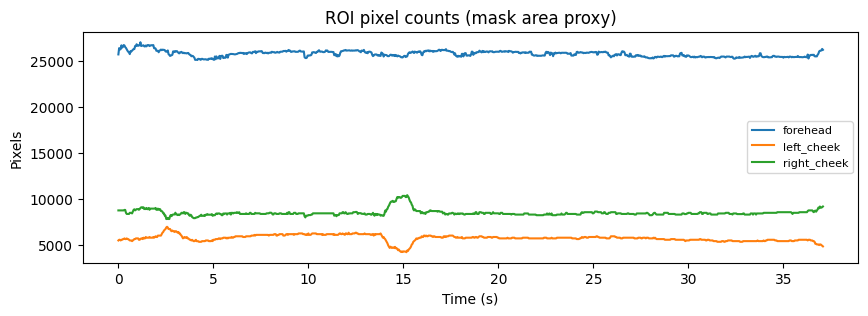

In [5]:
def interp_nans(x, min_valid_ratio=0.7):
    x = np.asarray(x, float)
    good = np.isfinite(x)
    if good.mean() < min_valid_ratio:
        return np.full_like(x, np.nan)
    if good.all():
        return x
    idx = np.arange(len(x))
    y = x.copy()
    y[~good] = np.interp(idx[~good], idx[good], x[good])
    return y

# RGB means per ROI
for roi, rgb in rois.items():
    plt.figure()
    plt.plot(t, interp_nans(rgb[:,0]), label="R")
    plt.plot(t, interp_nans(rgb[:,1]), label="G")
    plt.plot(t, interp_nans(rgb[:,2]), label="B")
    plt.title(f"Raw ROI mean RGB — {roi}")
    plt.xlabel("Time (s)")
    plt.ylabel("Mean intensity")
    plt.legend(ncol=3, fontsize=8)
    plt.show()

# ROI pixel area
if roi_pixels is not None:
    plt.figure()
    plt.plot(t, roi_pixels[:,0], label="forehead")
    plt.plot(t, roi_pixels[:,1], label="left_cheek")
    plt.plot(t, roi_pixels[:,2], label="right_cheek")
    plt.title("ROI pixel counts (mask area proxy)")
    plt.xlabel("Time (s)")
    plt.ylabel("Pixels")
    plt.legend(fontsize=8)
    plt.show()
else:
    print("roi_pixels not found in NPZ (your extractor can save it; recommended).")

## 2) rPPG extraction from ROI RGB

We compute rPPG using **POS** (recommended) plus optional baselines.

Tips:
- POS usually beats raw green channel.
- CHROM can be good under stable lighting.

In [6]:
def zscore(x):
    x = np.asarray(x, float)
    return (x - np.mean(x)) / (np.std(x) + 1e-12)

def bandpass(x, fs, lo=0.8, hi=3.0, order=3):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [lo/nyq, hi/nyq], btype="bandpass")
    return signal.filtfilt(b, a, np.asarray(x, float))

def pos_rppg(rgb, fs, win_sec=1.6, overlap=0.5):
    rgb = np.asarray(rgb, float)
    R = interp_nans(rgb[:,0]); G = interp_nans(rgb[:,1]); B = interp_nans(rgb[:,2])
    if not (np.all(np.isfinite(R)) and np.all(np.isfinite(G)) and np.all(np.isfinite(B))):
        return np.full(len(R), np.nan)
    C = np.vstack([R,G,B]).T
    C = C / (np.mean(C, axis=0, keepdims=True) + 1e-12)
    n = len(C)
    win = max(5, int(round(win_sec*fs)))
    hop = max(1, int(round(win*(1-overlap))))
    hann = signal.windows.hann(win, sym=False)
    out = np.zeros(n); wsum = np.zeros(n)
    P = np.array([[0, 1, -1],
                  [-2, 1,  1]], float)  # 2x3
    for s in range(0, n-win+1, hop):
        seg = C[s:s+win] - np.mean(C[s:s+win], axis=0, keepdims=True)
        X = seg @ P.T
        x1, x2 = X[:,0], X[:,1]
        alpha = np.std(x1) / (np.std(x2) + 1e-12)
        sig = x1 - alpha*x2
        sig -= np.mean(sig)
        out[s:s+win] += sig * hann
        wsum[s:s+win] += hann
    out /= np.maximum(wsum, 1e-12)
    out = signal.detrend(out, type="linear")
    out = bandpass(out, fs, 0.8, 3.0, 3)
    return zscore(out)

def green_rppg(rgb, fs):
    g = interp_nans(rgb[:,1])
    if not np.all(np.isfinite(g)): return np.full(len(g), np.nan)
    g = signal.detrend(g, type="linear")
    return zscore(bandpass(g, fs, 0.8, 3.0, 3))

rppg = {roi: pos_rppg(rgb, fps) for roi, rgb in rois.items()}

### 2.1 rPPG time plots (per ROI)

**Good:** clear quasi-periodic waveform, not crazy spikes.  
**Bad:** mostly noise, frequent large spikes, or long NaN segments.

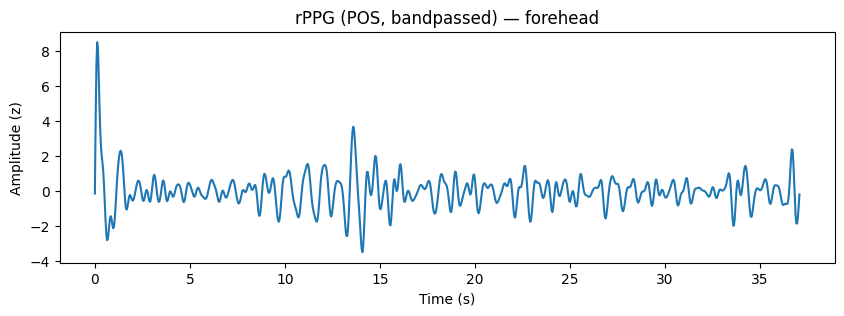

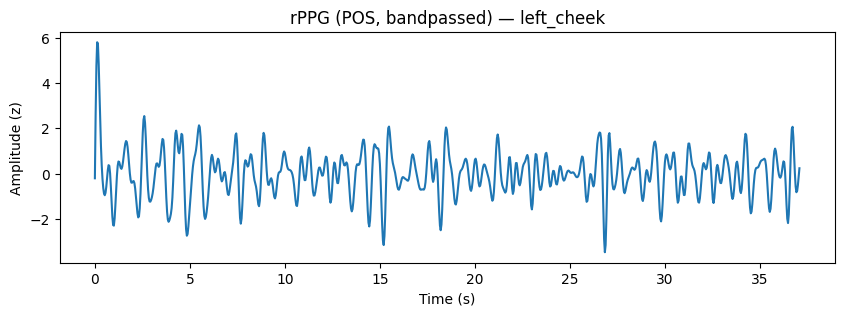

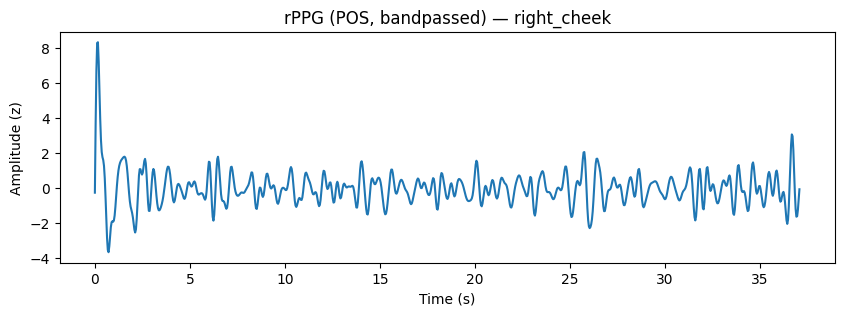

In [7]:
for roi, sig_ in rppg.items():
    plt.figure()
    plt.plot(t, sig_)
    plt.title(f"rPPG (POS, bandpassed) — {roi}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (z)")
    plt.show()

## 3) HR estimation + PSD and a simple quality score

We estimate HR from Welch PSD peak in 0.8–3.0 Hz (48–180 bpm).

We also compute a simple **SNR-like** metric:
- signal power = power near peak (±0.3 Hz)
- noise power = rest of band

Interpretation: higher is better. Negative values can happen in noisy clips.

In [8]:
def welch_hr_and_snr(x, fs, lo=0.8, hi=3.0, guard_hz=0.30):
    x = np.asarray(x, float)
    if not np.all(np.isfinite(x)):
        return np.nan, -np.inf, None, None, None
    f, p = signal.welch(x, fs=fs, nperseg=min(len(x), int(8*fs)))
    band = (f >= lo) & (f <= hi)
    if not np.any(band):
        return np.nan, -np.inf, f, p, None
    fb, pb = f[band], p[band]
    i0 = int(np.argmax(pb))
    f0 = float(fb[i0])
    bpm = 60.0 * f0

    num = (fb >= f0-guard_hz) & (fb <= f0+guard_hz)
    den = ~num
    p_num = float(np.sum(pb[num]) + 1e-12)
    p_den = float(np.sum(pb[den]) + 1e-12)
    snr_db = 10.0 * np.log10(p_num / p_den)
    return bpm, snr_db, f, p, f0

summary = []
psd_cache = {}
for roi, sig_ in rppg.items():
    bpm, snr_db, f, p, f0 = welch_hr_and_snr(sig_, fps)
    summary.append((roi, bpm, snr_db))
    psd_cache[roi] = (f, p, f0)

pd.DataFrame(summary, columns=["ROI","HR_bpm","SNR_dB"])

,ROI,HR_bpm,SNR_dB
0,forehead,67.506062,3.083230
1,left_cheek,67.506062,1.551500
2,right_cheek,60.005388,-1.423483


### 3.1 PSD overlay (ROIs)

**Good:** one dominant peak in the HR band and ROIs peaks near each other.  
**Bad:** flat PSD or peaks spread all over.

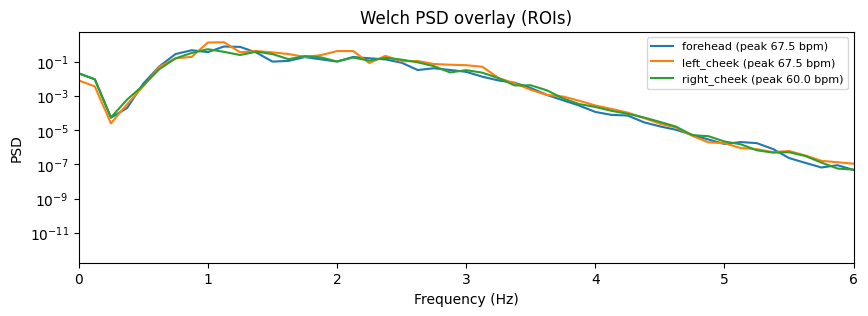

In [9]:
plt.figure()
for roi, (f, p, f0) in psd_cache.items():
    if f is None: 
        continue
    plt.semilogy(f, p, label=f"{roi} (peak {60*f0:.1f} bpm)")
plt.xlim(0, 6)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Welch PSD overlay (ROIs)")
plt.legend(fontsize=8)
plt.show()

## 4) Mode A: Validation WITH IR CSV (optional)

If you have `IR_CSV_PATH`, we:
1) load IR samples
2) bandpass 0.8–3.0 Hz
3) map IR signal onto video time (if no timestamps, sampling rate is estimated from duration)
4) compare:
   - HR agreement
   - PSD alignment
   - lag via cross-correlation
   - coherence (frequency-domain similarity)

**Note:** waveform correlation can be low even when HR is correct, because contact PPG waveform shape differs from face rPPG.

In [ ]:
def load_ir_csv(csv_path):
    df = pd.read_csv(csv_path)
    x = df.iloc[:,0].astype(float).to_numpy()  # first column
    return x

def best_lag(x, y, fs, max_lag_sec=2.0):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = min(len(x), len(y))
    x = x[:n]; y = y[:n]
    max_lag = int(round(max_lag_sec*fs))
    best = (-np.inf, 0.0, 1)
    for pol in (+1, -1):
        c = signal.correlate(pol*y, x, mode="full") / (n + 1e-12)
        lags = np.arange(-n+1, n)
        m = (lags >= -max_lag) & (lags <= max_lag)
        c2 = c[m]; l2 = lags[m]
        i = int(np.argmax(c2))
        peak = float(c2[i])
        lag_sec = float(l2[i] / fs)
        if peak > best[0]:
            best = (peak, lag_sec, pol)
    return best  # peak, lag_sec, polarity

def coherence_band(x, y, fs, lo=0.8, hi=3.0):
    f, Cxy = signal.coherence(x, y, fs=fs, nperseg=min(len(x), int(8*fs)))
    band = (f >= lo) & (f <= hi)
    return float(np.nanmean(Cxy[band])), f, Cxy

if IR_CSV_PATH is None:
    print("IR_CSV_PATH is None. Skip this section for now.")
else:
    ir_raw = load_ir_csv(IR_CSV_PATH)
    duration = float(t[-1] - t[0])
    fs_ir_est = float(len(ir_raw) / duration) if duration > 0 else np.nan

    ir_bp = bandpass(signal.detrend(ir_raw, type="linear"), fs_ir_est, 0.8, 3.0, 3)
    ir_bp = zscore(ir_bp)
    t_ir = np.arange(len(ir_raw)) / fs_ir_est

    # map IR onto video timeline
    ir_on_video = np.interp(t, t_ir, ir_bp)

    ir_hr, ir_snr_db, f_ir, p_ir, f0_ir = welch_hr_and_snr(ir_on_video, fps)

    print("Estimated IR fs:", fs_ir_est)
    print("IR HR:", ir_hr, "bpm", "SNR:", ir_snr_db, "dB")

    # PSD overlay: IR + ROIs
    plt.figure()
    plt.semilogy(f_ir, p_ir, label=f"IR peak {60*f0_ir:.1f} bpm")
    for roi, (f, p, f0) in psd_cache.items():
        plt.semilogy(f, p, label=f"{roi} peak {60*f0:.1f} bpm")
    plt.xlim(0, 6)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.title("Welch PSD overlay: IR vs ROIs")
    plt.legend(fontsize=8, ncol=2)
    plt.show()

    # Lag + coherence per ROI
    rows = []
    for roi, sig_ in rppg.items():
        peak, lag_sec, pol = best_lag(ir_on_video, sig_, fps, max_lag_sec=2.0)
        lag_samp = int(round(lag_sec*fps))
        aligned = zscore(pol*np.roll(sig_, -lag_samp))
        coh_mean, fcoh, Cxy = coherence_band(ir_on_video, aligned, fps)

        rows.append((roi, peak, lag_sec, pol, coh_mean))

    display(pd.DataFrame(rows, columns=["ROI","xcorr_peak","lag_sec","polarity","coherence_mean_0.8-3Hz"]))

    # Visualize best ROI waveform overlay (by xcorr peak)
    best_roi = max(rows, key=lambda r: r[1])[0]
    peak, lag_sec, pol = [r[1:] for r in rows if r[0] == best_roi][0]
    lag_samp = int(round(lag_sec*fps))
    aligned = zscore(pol*np.roll(rppg[best_roi], -lag_samp))
    irz = zscore(ir_on_video)

    seg = slice(int(5*fps), int(min(len(t), 25*fps)))
    plt.figure()
    plt.plot(t[seg], irz[seg], label="IR (bandpassed)")
    plt.plot(t[seg], aligned[seg], label=f"rPPG {best_roi} aligned (lag≈{lag_sec*1000:.0f} ms)")
    plt.title(f"Waveform overlay (segment) — best ROI={best_roi}, xcorr≈{peak:.2f}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (z)")
    plt.legend(fontsize=8)
    plt.show()

## 5) Mode B: Validation WITHOUT IR (repeatability / agreement)

When you don’t have IR ground truth, you can still rate the clip by:

1) **ROI agreement**: do ROIs estimate the same HR?
2) **ROI quality**: does each ROI have a stable PSD peak (SNR) and stable pixel area?

### Suggested rule-of-thumb (per window)
- Accept a window if at least **2 ROIs** are valid and their HRs are within **±6 bpm**
- Final HR = median of valid ROI HRs (robust to outliers)

In [10]:
def hr_track(x, fs, win_sec=12.0, hop_sec=1.0, lo=0.8, hi=3.0):
    win = int(round(win_sec*fs))
    hop = int(round(hop_sec*fs))
    times, bpms, snrs = [], [], []
    for start in range(0, len(x)-win+1, hop):
        seg = x[start:start+win]
        bpm, snr_db, _, _, _ = welch_hr_and_snr(seg, fs, lo, hi)
        times.append((start+win/2)/fs)
        bpms.append(bpm)
        snrs.append(snr_db)
    return np.array(times), np.array(bpms), np.array(snrs)

tracks = {}
for roi, sig_ in rppg.items():
    tt, hb, sn = hr_track(sig_, fps, win_sec=12.0, hop_sec=1.0)
    tracks[roi] = dict(t=tt, hr=hb, snr=sn)

# Combine into a table on the common time grid
grid = tracks[list(tracks.keys())[0]]["t"]
H = np.vstack([tracks[roi]["hr"] for roi in tracks.keys()]).T  # (T_windows, 3)
S = np.vstack([tracks[roi]["snr"] for roi in tracks.keys()]).T

roi_list = list(tracks.keys())
df_hr = pd.DataFrame(H, columns=[f"HR_{r}" for r in roi_list])
df_snr = pd.DataFrame(S, columns=[f"SNR_{r}" for r in roi_list])
df = pd.concat([pd.Series(grid, name="t_sec"), df_hr, df_snr], axis=1)
df.head()

,t_sec,HR_forehead,HR_left_cheek,HR_right_cheek,SNR_forehead,SNR_left_cheek,SNR_right_cheek
0,5.999461,60.005388,67.506062,90.008083,-0.390200,4.612028,-0.715389
1,6.999371,60.005388,60.005388,90.008083,2.092415,4.517176,-2.323540
2,7.999282,60.005388,60.005388,60.005388,5.528471,3.349977,-3.252054
3,8.999192,67.506062,60.005388,60.005388,8.102119,0.761307,-2.044409
4,9.999102,67.506062,67.506062,60.005388,7.483928,1.295928,-0.911781


Acceptance rate: 0.4230769230769231


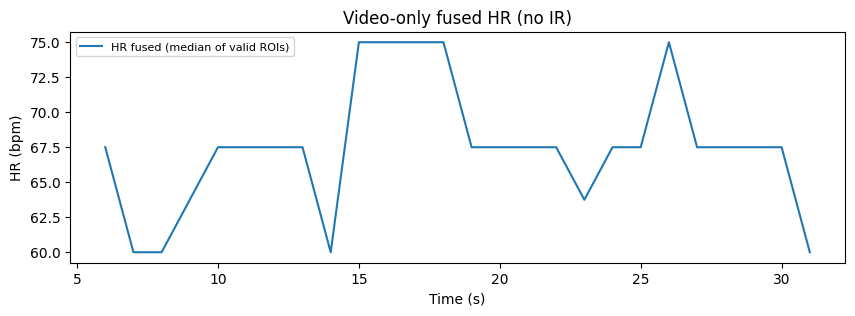

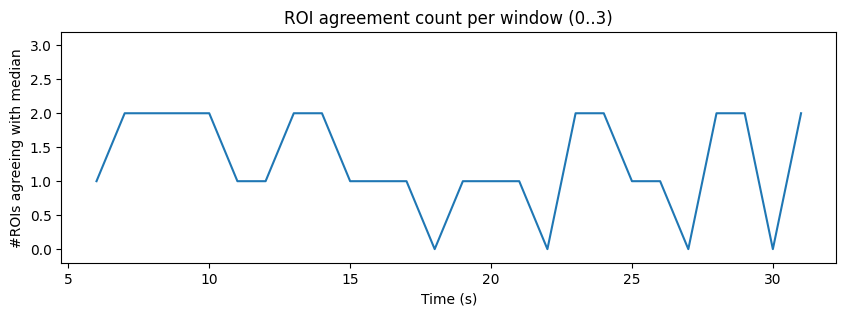

In [11]:
# Agreement score per window
# valid ROI if SNR > threshold and HR finite
SNR_TH = -2.0  # start permissive; tighten later (e.g. 0 dB)
AGREE_BPM = 6.0

valid = np.isfinite(H) & (S > SNR_TH)
hr_med = np.nanmedian(np.where(valid, H, np.nan), axis=1)

# Count how many valid ROIs agree with median within ±AGREE_BPM
agree = np.zeros(len(grid), int)
for i in range(len(grid)):
    if not np.isfinite(hr_med[i]): 
        agree[i] = 0
        continue
    agree[i] = int(np.sum(valid[i] & (np.abs(H[i] - hr_med[i]) <= AGREE_BPM)))

# "window accepted" if at least 2 ROIs agree
accepted = agree >= 2
accept_rate = float(np.mean(accepted))

print("Acceptance rate:", accept_rate)

plt.figure()
plt.plot(grid, hr_med, label="HR fused (median of valid ROIs)")
plt.title("Video-only fused HR (no IR)")
plt.xlabel("Time (s)")
plt.ylabel("HR (bpm)")
plt.legend(fontsize=8)
plt.show()

plt.figure()
plt.plot(grid, agree)
plt.ylim(-0.2, 3.2)
plt.title("ROI agreement count per window (0..3)")
plt.xlabel("Time (s)")
plt.ylabel("#ROIs agreeing with median")
plt.show()

## 6) Interpretation checklist (what to look for)

### If you have IR
- HR (bpm) from best ROI should be close to IR (overall + track).
- Lag should be stable (doesn’t jump across windows).
- PSD peaks should align.

### If you do NOT have IR
- ROIs should mostly agree (≥2 agreeing for a high fraction of windows).
- If one ROI often disagrees (e.g. beard side), keep it but **downweight** it:
  - use SNR threshold
  - use pixel stability threshold
  - use agreement filtering

### Red flags
- `roi_pixels` collapses or oscillates strongly (skin mask instability).
- HR tracks jump rapidly (e.g. 60→120→70 bpm), especially if PSD peak is broad.
- Agreement is low (<40% accepted windows): your clip is not reliable for rPPG.

## 7) Next improvements (optional)

- Add multi-patch cheeks (e.g., 2×2 patches each cheek) and fuse them with weighted median.
- Replace HSV mask with YCrCb (already supported here) or face-parsing segmentation (best).
- Save IR with timestamps or an explicit sample rate for perfect alignment.